In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy import stats
import itertools as it

In [54]:
manudf = pd.read_csv('../raw/20231003-Max-raw-data.csv')
coilstart = manudf.iloc[:7, 4:9].values.flatten()
inoctime = manudf.iloc[:7, 10:15].values.flatten()
manu = {'9am': np.column_stack((coilstart, inoctime))}

coilstart = manudf.iloc[7:14, 4:9].values.flatten()
inoctime = manudf.iloc[7:14, 10:15].values.flatten()
mask = np.isnan(coilstart) | np.isnan(inoctime)
manu['12pm'] = np.column_stack((coilstart[~mask], inoctime[~mask]))

coilstart = manudf.iloc[14:, 4:9].values.flatten()
inoctime = manudf.iloc[14:, 10:15].values.flatten()
mask = np.isnan(coilstart) | np.isnan(inoctime)
manu['4pm'] = np.column_stack((coilstart[~mask], inoctime[~mask]))

In [5]:
colors = ['#117733', '#aa4499', '#332288', '#44aa99', '#88ccee', '#ddcc77']
markers = ['D','o','^','v','<','>','*']
fs = 20

src = '../proc/prelim/'
dst = '../proc/plots/'
csvfiles = glob(src + '*/*.csv')
Times = ['9am','12pm','4pm']
csvfiles[:5]

['../proc/prelim/4pm_rep4/4pm_rep4_plant_01.csv',
 '../proc/prelim/4pm_rep4/4pm_rep4_plant_02.csv',
 '../proc/prelim/4pm_rep4/4pm_rep4_plant_00.csv',
 '../proc/prelim/4pm_rep4/4pm_rep4_plant_03.csv',
 '../proc/prelim/9am_rep2/9am_rep2_plant_03.csv']

In [3]:
dfs = dict(zip(Times, [ [] for i in range(len(Times)) ] ))
meta = dict(zip(Times, [ [] for i in range(len(Times)) ] ))

for i in range(len(csvfiles)):
    time, rep, _, pidx = os.path.splitext(os.path.split(csvfiles[i])[1])[0].split('_')
    df = pd.read_csv(csvfiles[i])
    df['timestamp'] *= 96/3600
    df = df.iloc[np.argmax((df.pos_raw_1 != -100).values):, :]
    if (df.shape[1]-1)//6 > 1:
        dfs[time].append(df)
        meta[time].append(np.asarray([rep[-1], pidx, *df.shape]).astype(int))

for key in meta:
    meta[key] = np.asarray(meta[key])
    print(key, '\t', meta[key].shape)

9am 	 (34, 4)
12pm 	 (21, 4)
4pm 	 (28, 4)


# Plot all individual cuscutas at once

In [6]:
dst + 'all_positions'

'../proc/plots/all_positions'

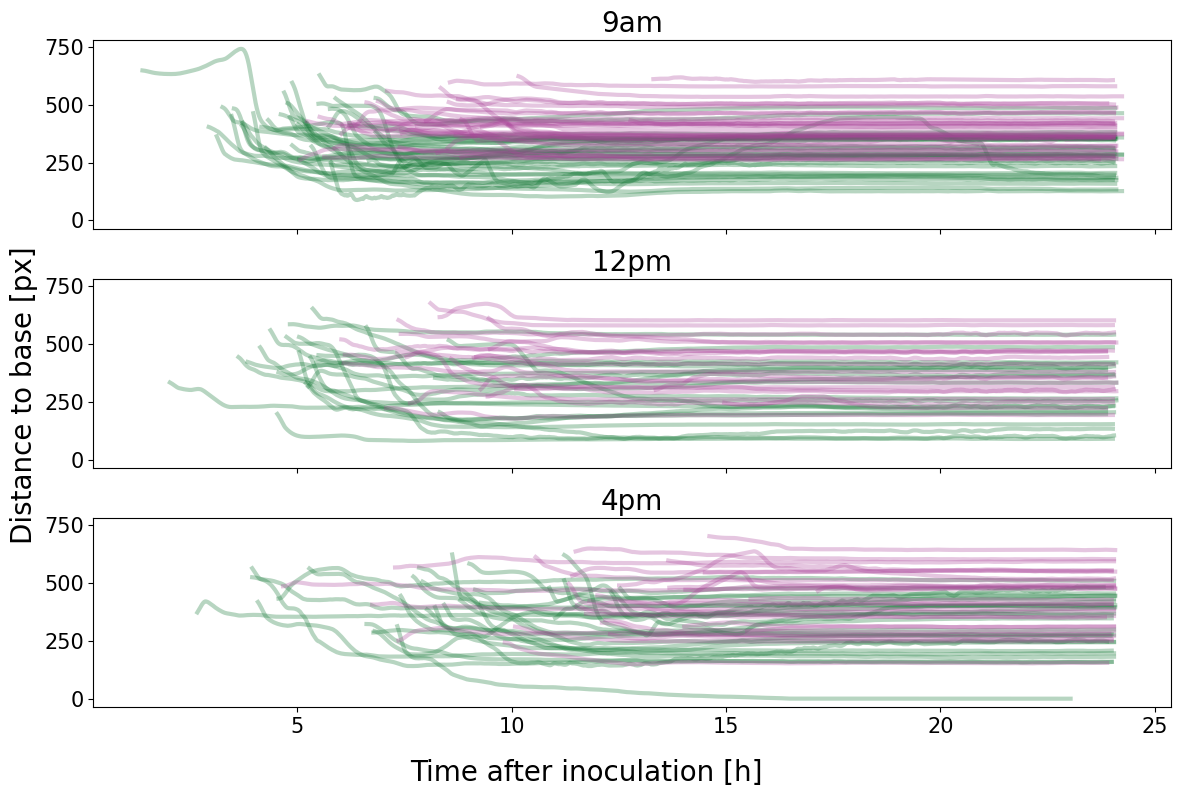

In [8]:
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(len(Times)):
    key = Times[k]
    ax[k].set_title(Times[k], fontsize=fs)
    for i in range(len(dfs[key])):
        df = dfs[key][i]
        
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            rposlab = 'pos_raw_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            mask = df[rposlab] > 0
            ax[k].plot(df['timestamp'].loc[mask], df[poslab].loc[mask], lw=3, color=colors[j], alpha=0.3, zorder=j+1)

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-5)
            
fig.supxlabel('Time after inoculation [h]', fontsize=fs)
fig.supylabel('Distance to base [px]', fontsize=fs)
fig.tight_layout()

filename = dst + 'all_positions'
plt.savefig(filename + '.svg', format='svg', dpi=200, bbox_inches='tight')
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

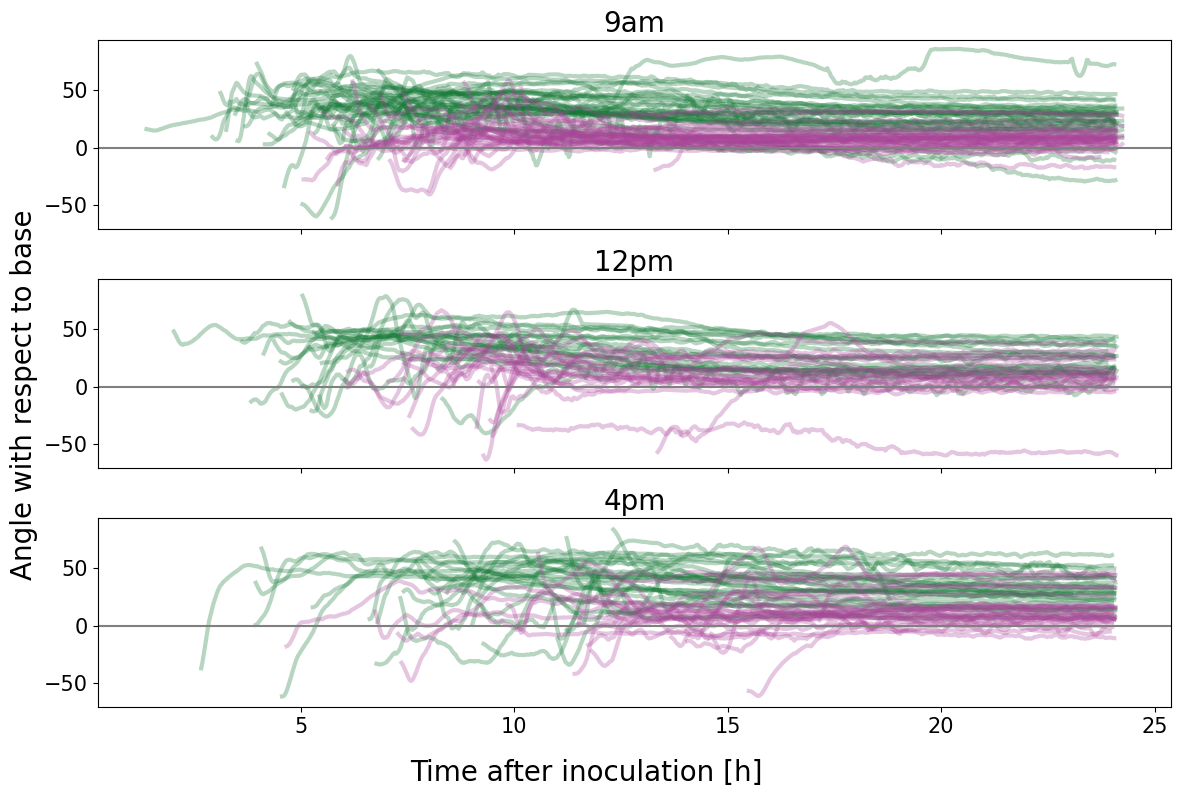

In [9]:
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(len(Times)):
    key = Times[k]
    ax[k].set_title(Times[k], fontsize=fs)
    for i in range(len(dfs[key])):
        df = dfs[key][i]
        
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            rposlab = 'pos_raw_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            mask = df[rposlab] > 0
            ax[k].plot(df['timestamp'].loc[mask], df[anglab].loc[mask], lw=3, color=colors[j], alpha=0.3, zorder=j+1)

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-5)
    ax[i].axhline(0, c='gray')
            
fig.supxlabel('Time after inoculation [h]', fontsize=fs)
fig.supylabel('Angle with respect to base', fontsize=fs)
fig.tight_layout()

filename = dst + 'all_angles'
plt.savefig(filename + '.svg', format='svg', dpi=200, bbox_inches='tight')
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

# Find at which timestamp the cuscuta gets infront of the skewer

## Then at which timestamp the cuscuta gets infront of the skewer for a 2nd time

### The latter can be seen as the time it takes cuscuta to coil itself around the skewer.

We then perform Mann-Whitney U-tests to see if the differences are statistically significant

In [10]:
times = dict()

for key in dfs:
    time = np.random.default_rng(42).normal(0, 0.1, size=(len(dfs[key]), 2))
    for i in range(len(dfs[key])):
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            rposlab = 'pos_raw_{}'.format(j+1)
    
            mask = dfs[key][i][rposlab] > 0
            time[i,j] += dfs[key][i]['timestamp'].iloc[np.argmax(mask)]

    times[key] = time

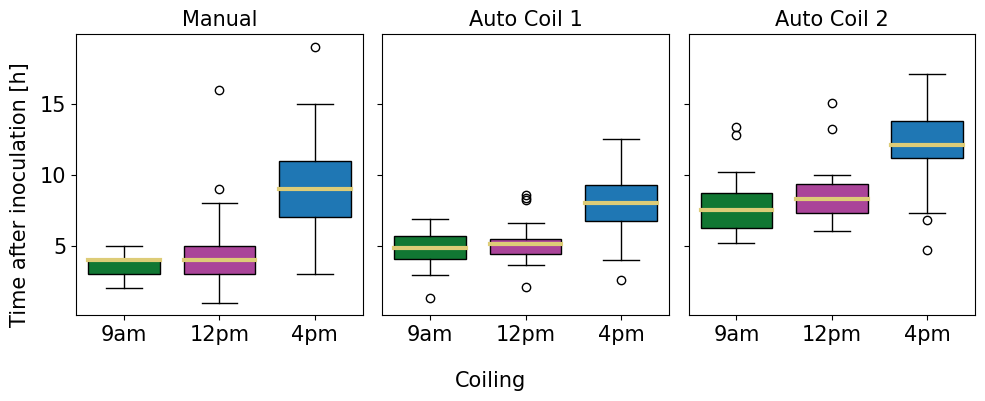

In [74]:
fs = 15

fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()    

ax[0].set_title('Manual', fontsize=fs)
foo = [manu[Times[i]][:,0] for i in range(len(Times))]
bplot = ax[0].boxplot(foo, widths=0.75, patch_artist=True, 
                  medianprops={'lw':3, 'color':colors[5]})
for patch, color in zip(bplot['boxes'], colors[:2]):
    patch.set_facecolor(color)


ax[1].set_title('Auto Coil 1', fontsize=fs)
foo = [times[Times[i]][:,0] for i in range(len(Times))]
bplot = ax[1].boxplot(foo, widths=0.75, patch_artist=True, 
                  medianprops={'lw':3, 'color':colors[5]})
for patch, color in zip(bplot['boxes'], colors[:2]):
    patch.set_facecolor(color)

ax[2].set_title('Auto Coil 2', fontsize=fs)
foo = [times[Times[i]][:,1] for i in range(len(Times))]
bplot = ax[2].boxplot(foo, widths=0.75, patch_artist=True, 
                  medianprops={'lw':3, 'color':colors[5]})
for patch, color in zip(bplot['boxes'], colors[:2]):
    patch.set_facecolor(color)

for i in range(len(ax)):
    ax[i].margins(0.05)
    ax[i].set_xticks(range(1,4), Times)
    ax[i].tick_params(labelsize=fs)

fig.supxlabel('Coiling', fontsize=fs)
fig.supylabel('Time after inoculation [h]', fontsize=fs)
fig.tight_layout();

filename = dst + 'time_after_inoculation'
#plt.savefig(filename + '.svg', format='svg', dpi=200, bbox_inches='tight')
#plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [67]:
for i,j in it.combinations(range(len(Times)), 2):
    for k in range(2):
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(times[Times[i]][:,k], times[Times[j]][:, k], method='exact'))
    print('---')

Coil 1 	 9am vs 12pm 	 MannwhitneyuResult(statistic=319.0, pvalue=0.5191502905841494)
Coil 2 	 9am vs 12pm 	 MannwhitneyuResult(statistic=254.0, pvalue=0.07564359740511707)
---
Coil 1 	 9am vs 4pm 	 MannwhitneyuResult(statistic=151.0, pvalue=1.23975173379322e-06)
Coil 2 	 9am vs 4pm 	 MannwhitneyuResult(statistic=124.0, pvalue=9.914453424252958e-08)
---
Coil 1 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=127.0, pvalue=0.0005260516677429119)
Coil 2 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=107.0, pvalue=8.456304762066346e-05)
---


In [50]:
speed = dict()

for key in dfs:
    #s = np.random.default_rng(42).normal(0, 0.1, len(dfs[key]))
    s = np.diff(times[key], axis=1).squeeze().astype(float)
    speed[key] = s

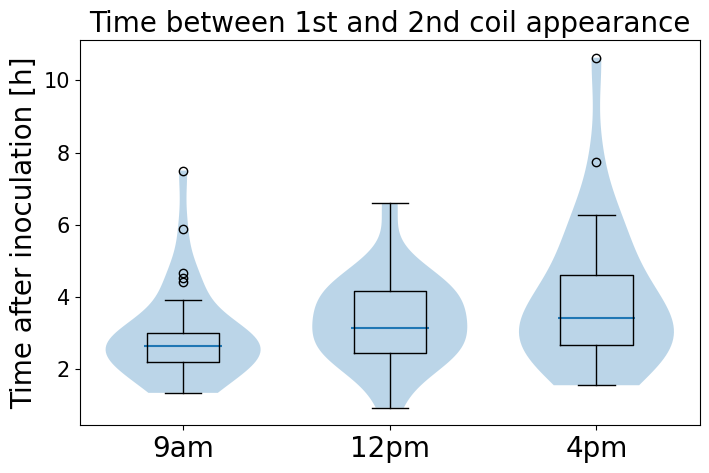

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,5), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel(); i=0

vplot = ax[i].violinplot([speed[key] for key in speed], widths=0.75, showmedians=True, showextrema=False)
bplot = ax[i].boxplot([speed[key] for key in speed], widths=0.35, patch_artist=False, medianprops={'lw':3, 'color':colors[5], 'alpha':0}, zorder=3)

ax[i].tick_params('y', labelsize=fs-5);
ax[i].set_xticks(np.arange(len(Times)) + 1, Times, fontsize=fs);
ax[i].set_ylabel('Time after inoculation [h]', fontsize=fs)
ax[i].set_title('Time between 1st and 2nd coil appearance', fontsize=fs);

In [54]:
for i,j in it.combinations(range(len(Times)), 2):
    print(Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(speed[Times[i]], speed[Times[j]], method='exact'))

9am vs 12pm 	 MannwhitneyuResult(statistic=265.0, pvalue=0.11347049559413055)
9am vs 4pm 	 MannwhitneyuResult(statistic=310.0, pvalue=0.01846832488264103)
12pm vs 4pm 	 MannwhitneyuResult(statistic=262.0, pvalue=0.5279580244565482)


# Most of the cuscutas reach a terminal angle and position

## Compare the final position and angle across inoculation times

In [57]:
buff = 50
angles = dict()
positions = dict()

for key in dfs:
    angle = np.zeros((len(dfs[key]), 2))
    position = np.copy(angle)
    
    for i in range(len(angle)):
        df = dfs[key][i].iloc[-buff-10:-10]
        for j in range(2):
            anglab = 'angle_sg_{}'.format(j+1)
            poslab = 'pos_sg_{}'.format(j+1)
            
            angle[i,j] = np.median(df[anglab].values)
            position[i,j] = np.median(df[poslab].values)

    angles[key] = angle
    positions[key] = position

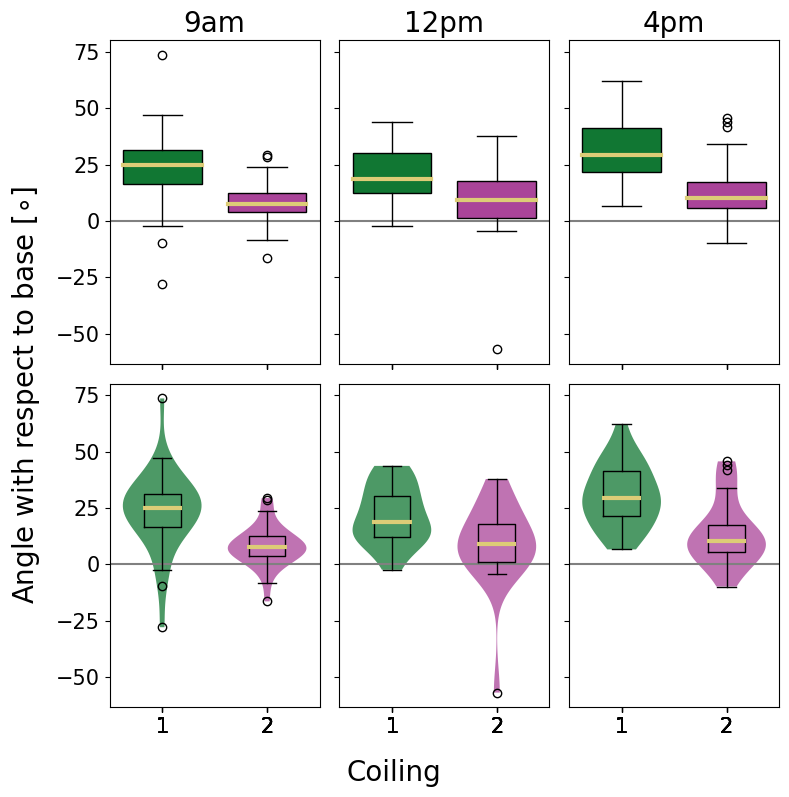

In [58]:
fig, ax = plt.subplots(2,3, figsize=(8,8), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()
for i in range(len(Times)):
    
    bplot = ax[i].boxplot(angles[Times[i]], widths=0.75, patch_artist=True, 
                          medianprops={'lw':3, 'color':colors[5]})
    
    for patch, color in zip(bplot['boxes'], colors[:2]):
        patch.set_facecolor(color)
    ax[i].set_title(Times[i], fontsize=fs)

    j = len(Times) + i
    vplot = ax[j].violinplot(angles[Times[i]], widths=0.75, showmedians=True, showextrema=False)
    bplot = ax[j].boxplot(angles[Times[i]], widths=0.35, patch_artist=False, medianprops={'lw':3, 'color':colors[5], 'alpha':0}, zorder=3)
    
    for patch, color in zip(vplot['bodies'], colors[:2]):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    #vplot['cbars'].set_color('k')
    vplot['cmedians'].set_color(colors[5])
    vplot['cmedians'].set_lw(3)
    vplot['cmedians'].set_zorder(5)

for i in range(len(ax)):
    ax[i].margins(0.05)
    ax[i].tick_params(labelsize=fs-5)
    ax[i].axhline(0, c='gray', zorder=1)

fig.supxlabel('Coiling', fontsize=fs)
fig.supylabel('Angle with respect to base [$\circ$]', fontsize=fs)
fig.tight_layout();

In [14]:
for i,j in it.combinations(range(len(Times)), 2):
    for k in range(2):
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(angles[Times[i]][:,k], angles[Times[j]][:, k], method='exact'))
    print('---')

Coil 1 	 9am vs 12pm 	 MannwhitneyuResult(statistic=403.0, pvalue=0.4338395317066418)
Coil 2 	 9am vs 12pm 	 MannwhitneyuResult(statistic=323.0, pvalue=0.5647846285545649)
---
Coil 1 	 9am vs 4pm 	 MannwhitneyuResult(statistic=371.0, pvalue=0.14018214652516212)
Coil 2 	 9am vs 4pm 	 MannwhitneyuResult(statistic=376.0, pvalue=0.16037340617568932)
---
Coil 1 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=193.0, pvalue=0.041547550303084824)
Coil 2 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=261.0, pvalue=0.514907694503373)
---


In [15]:
for i in range(len(Times)):
    print(Times[i], '\tcoil 1 vs 2\t', stats.mannwhitneyu(angles[Times[i]][:,0], angles[Times[i]][:,1], method='exact'))

9am 	coil 1 vs 2	 MannwhitneyuResult(statistic=955.0, pvalue=1.2352880510969287e-06)
12pm 	coil 1 vs 2	 MannwhitneyuResult(statistic=326.0, pvalue=0.007289050357288072)
4pm 	coil 1 vs 2	 MannwhitneyuResult(statistic=628.0, pvalue=6.165322952547149e-05)


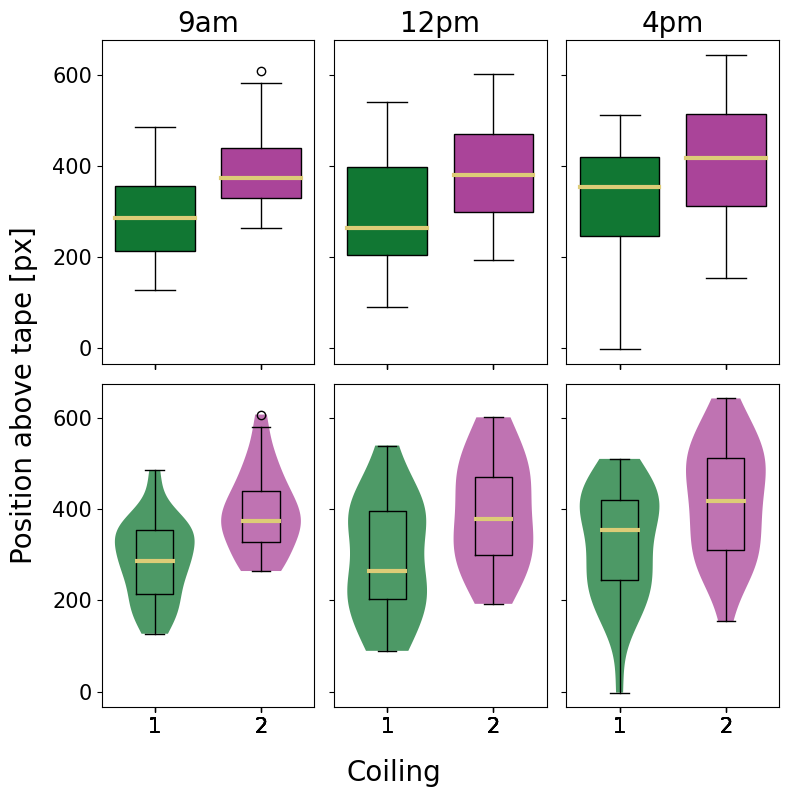

In [16]:
fig, ax = plt.subplots(2,3, figsize=(8,8), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()
for i in range(len(Times)):
    
    bplot = ax[i].boxplot(positions[Times[i]], widths=0.75, patch_artist=True, 
                          medianprops={'lw':3, 'color':colors[5]})
    
    for patch, color in zip(bplot['boxes'], colors[:2]):
        patch.set_facecolor(color)
    ax[i].set_title(Times[i], fontsize=fs)

    j = len(Times) + i
    vplot = ax[j].violinplot(positions[Times[i]], widths=0.75, showmedians=True, showextrema=False)
    bplot = ax[j].boxplot(positions[Times[i]], widths=0.35, patch_artist=False, medianprops={'lw':3, 'color':colors[5], 'alpha':0}, zorder=3)
    
    for patch, color in zip(vplot['bodies'], colors[:2]):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    #vplot['cbars'].set_color('k')
    vplot['cmedians'].set_color(colors[5])
    vplot['cmedians'].set_lw(3)
    vplot['cmedians'].set_zorder(5)

for i in range(len(ax)):
    ax[i].margins(0.05)
    ax[i].tick_params(labelsize=fs-5)
    #ax[i].axhline(0, c='gray', zorder=1)

fig.supxlabel('Coiling', fontsize=fs)
fig.supylabel('Position above tape [px]', fontsize=fs)
fig.tight_layout();

In [17]:
for i,j in it.combinations(range(len(Times)), 2):
    for k in range(2):
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(positions[Times[i]][:,k], positions[Times[j]][:, k], method='exact'))
    print('---')

Coil 1 	 9am vs 12pm 	 MannwhitneyuResult(statistic=340.0, pvalue=0.7768949271799602)
Coil 2 	 9am vs 12pm 	 MannwhitneyuResult(statistic=364.0, pvalue=0.911134706914424)
---
Coil 1 	 9am vs 4pm 	 MannwhitneyuResult(statistic=374.0, pvalue=0.15205167856967639)
Coil 2 	 9am vs 4pm 	 MannwhitneyuResult(statistic=408.0, pvalue=0.3422033832684302)
---
Coil 1 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=242.0, pvalue=0.3011174841018669)
Coil 2 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=250.0, pvalue=0.3829037977760806)
---


# Check the distance between the two coils

In [18]:
tight = dict()

for key in dfs:
    s = np.diff(positions[key], axis=1).squeeze().astype(float)
    tight[key] = s

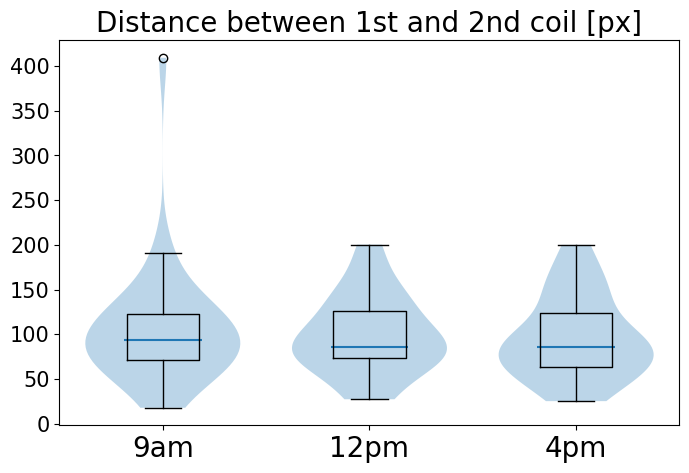

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,5), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel(); i=0

vplot = ax[i].violinplot([tight[key] for key in speed], widths=0.75, showmedians=True, showextrema=False)
bplot = ax[i].boxplot([tight[key] for key in speed], widths=0.35, patch_artist=False, medianprops={'lw':3, 'color':colors[5], 'alpha':0}, zorder=3)

ax[i].tick_params('y', labelsize=fs-5);
ax[i].set_xticks(np.arange(len(Times)) + 1, Times, fontsize=fs);
ax[i].set_title('Distance between 1st and 2nd coil [px]', fontsize=fs);

In [20]:
for i,j in it.combinations(range(len(Times)), 2):
    print(Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(tight[Times[i]], tight[Times[j]], method='exact'))

9am vs 12pm 	 MannwhitneyuResult(statistic=353.0, pvalue=0.952080192482042)
9am vs 4pm 	 MannwhitneyuResult(statistic=506.0, pvalue=0.6786101649679868)
12pm vs 4pm 	 MannwhitneyuResult(statistic=312.0, pvalue=0.7260983116056668)


# Check at which timestamp the cuscuta stops varying its position

## Consider how fast the cuscuta gets to this terminal position

In [59]:
tol = 10

stables = dict()
quicks = dict()

for key in dfs:
    stable = np.zeros((len(dfs[key]), 2))
    quick = np.copy(stable)
    
    for i in range(len(stable)):
        for j in range(2):
            poslab = 'pos_sg_{}'.format(j+1)
            mask = np.abs(dfs[key][i][poslab] - positions[key][i,j]) < tol
            foo = np.nonzero(mask)[0]
            bar = np.nonzero(np.ediff1d(foo) != 1)[0]
            if len(bar) == 0:
                tt = foo[0]
            else:
                tt = foo[bar[-1]]

            stable[i,j] = dfs[key][i].loc[:, ['timestamp', poslab]].iloc[tt:, :].iloc[0,0]
            quick[i,j] = stable[i,j] - times[key][i,j]
            
    quicks[key] = quick
    stables[key] = stable

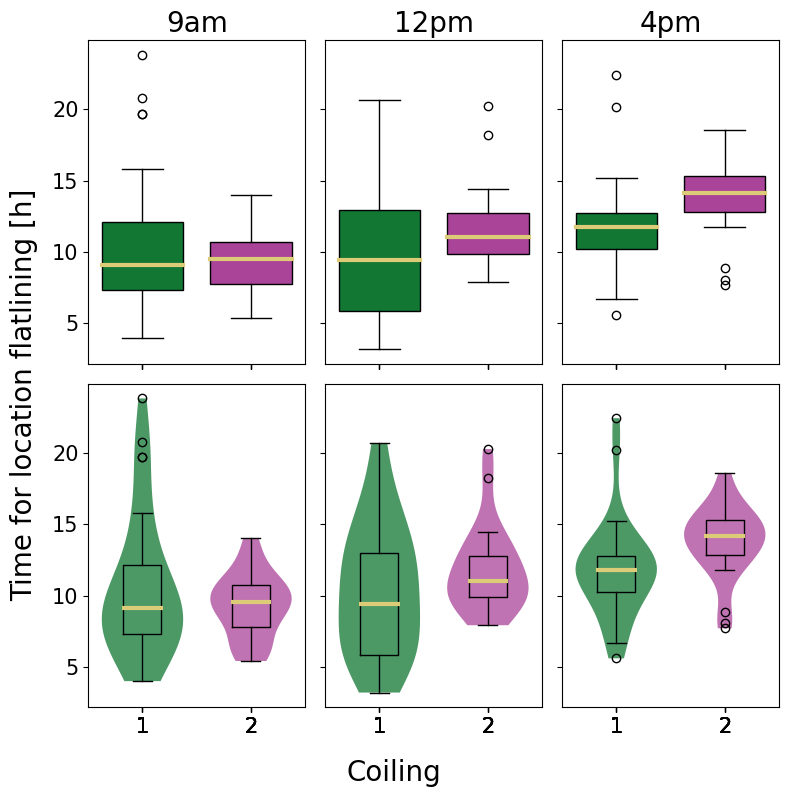

In [61]:
fig, ax = plt.subplots(2,3, figsize=(8,8), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()
for i in range(len(Times)):
    
    bplot = ax[i].boxplot(stables[Times[i]], widths=0.75, patch_artist=True, 
                          medianprops={'lw':3, 'color':colors[5]})
    
    for patch, color in zip(bplot['boxes'], colors[:2]):
        patch.set_facecolor(color)
    ax[i].set_title(Times[i], fontsize=fs)

    j = len(Times) + i
    vplot = ax[j].violinplot(stables[Times[i]], widths=0.75, showmedians=True, showextrema=False)
    bplot = ax[j].boxplot(stables[Times[i]], widths=0.35, patch_artist=False, medianprops={'lw':3, 'color':colors[5], 'alpha':0}, zorder=3)
    
    for patch, color in zip(vplot['bodies'], colors[:2]):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    #vplot['cbars'].set_color('k')
    vplot['cmedians'].set_color(colors[5])
    vplot['cmedians'].set_lw(3)
    vplot['cmedians'].set_zorder(5)

for i in range(len(ax)):
    ax[i].margins(0.05)
    ax[i].tick_params(labelsize=fs-5)

fig.supxlabel('Coiling', fontsize=fs)
fig.supylabel('Time for location flatlining [h]', fontsize=fs)
fig.tight_layout();

In [63]:
for i,j in it.combinations(range(len(Times)), 2):
    for k in range(2):
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(stables[Times[i]][:,k], stables[Times[j]][:, k], method='exact'))
    print('---')

Coil 1 	 9am vs 12pm 	 MannwhitneyuResult(statistic=348.0, pvalue=0.883959327483295)
Coil 2 	 9am vs 12pm 	 MannwhitneyuResult(statistic=185.0, pvalue=0.002460476133653802)
---
Coil 1 	 9am vs 4pm 	 MannwhitneyuResult(statistic=327.0, pvalue=0.03501706658573666)
Coil 2 	 9am vs 4pm 	 MannwhitneyuResult(statistic=98.5, pvalue=6.6539891824766314e-09)
---
Coil 1 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=236.5, pvalue=0.25628096525734484)
Coil 2 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=155.0, pvalue=0.004433372186538925)
---


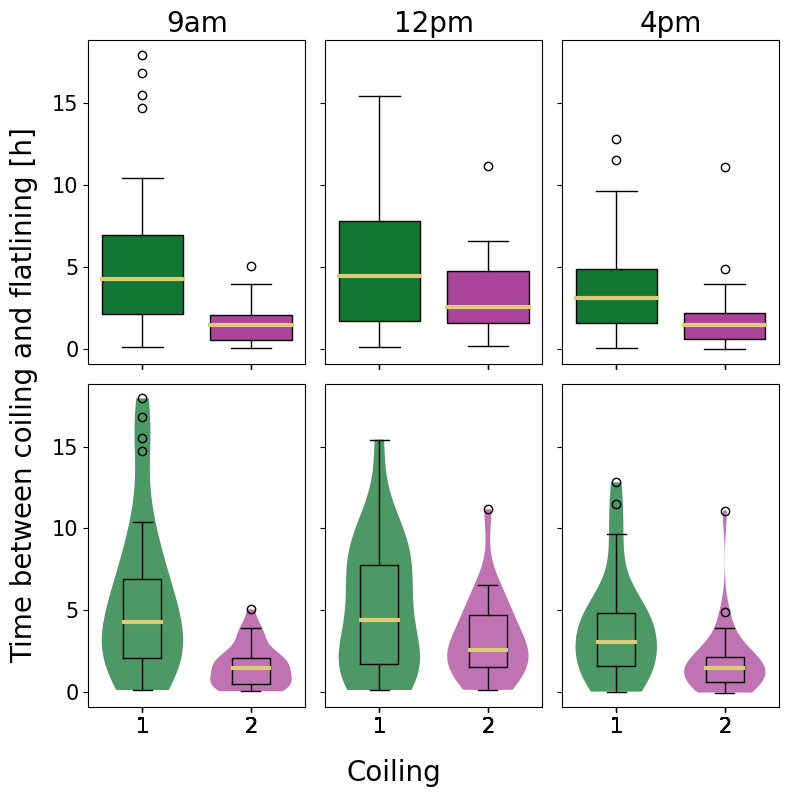

In [64]:
fig, ax = plt.subplots(2,3, figsize=(8,8), sharey=True, sharex=True)
ax = np.atleast_1d(ax).ravel()
for i in range(len(Times)):
    
    bplot = ax[i].boxplot(quicks[Times[i]], widths=0.75, patch_artist=True, 
                          medianprops={'lw':3, 'color':colors[5]})
    
    for patch, color in zip(bplot['boxes'], colors[:2]):
        patch.set_facecolor(color)
    ax[i].set_title(Times[i], fontsize=fs)

    j = len(Times) + i
    vplot = ax[j].violinplot(quicks[Times[i]], widths=0.75, showmedians=True, showextrema=False)
    bplot = ax[j].boxplot(quicks[Times[i]], widths=0.35, patch_artist=False, medianprops={'lw':3, 'color':colors[5], 'alpha':0}, zorder=3)
    
    for patch, color in zip(vplot['bodies'], colors[:2]):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    #vplot['cbars'].set_color('k')
    vplot['cmedians'].set_color(colors[5])
    vplot['cmedians'].set_lw(3)
    vplot['cmedians'].set_zorder(5)

for i in range(len(ax)):
    ax[i].margins(0.05)
    ax[i].tick_params(labelsize=fs-5)

fig.supxlabel('Coiling', fontsize=fs)
fig.supylabel('Time between coiling and flatlining [h]', fontsize=fs)
fig.tight_layout();

In [65]:
for i,j in it.combinations(range(len(Times)), 2):
    for k in range(2):
        print('Coil', k+1, '\t', Times[i],'vs',Times[j],'\t', stats.mannwhitneyu(quicks[Times[i]][:,k], quicks[Times[j]][:, k], method='exact'))
    print('---')

Coil 1 	 9am vs 12pm 	 MannwhitneyuResult(statistic=375.0, pvalue=0.7637572996635474)
Coil 2 	 9am vs 12pm 	 MannwhitneyuResult(statistic=205.0, pvalue=0.0078743918605567)
---
Coil 1 	 9am vs 4pm 	 MannwhitneyuResult(statistic=578.0, pvalue=0.15205167856967639)
Coil 2 	 9am vs 4pm 	 MannwhitneyuResult(statistic=461.0, pvalue=0.8386633493468196)
---
Coil 1 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=343.0, pvalue=0.330340647999825)
Coil 2 	 12pm vs 4pm 	 MannwhitneyuResult(statistic=414.5, pvalue=0.01478538122511289)
---
